In [ ]:
import torch
import itertools
import pandas as pd
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return list(zip(a, b))

In [ ]:
# Dataset construction
data = pd.read_csv('../data/final.csv').fillna(-1)
dataset = (pairwise(list(data.iterrows())))

In [ ]:
feature_selection = ["timepoint", "gender_x", "age_x", "Temperature_max", "Temperature_min", "WBC_max", "WBC_min", "Glucose_max", "Glucose_min", "Sodium_max", "Sodium_min", "Intubated_max", "Intubated_min", "Lactate_max", "Lactate_min", "PLE_max", "PLE_min", "HR_max", "HR_min", "PtS_max", "PtS_min", "Respiratory Rate (Total)_max", "Respiratory Rate (Total)_min", "Respiratory Rate_max", "Respiratory Rate_min", "Respiratory Rate (spontaneous)_max", "Respiratory Rate (spontaneous)_min", "NBPs_max", "NBPs_min", "ART BP Systolic_max", "ART BP Systolic_min", "Temperature C_max", "Temperature C_min", "Manual BPs R_max", "Manual BPs R_min", "Manual BPs L_max", "Manual BPs L_min", "Temperature F_max", "Temperature F_min", "ABPs_max", "ABPs_min"]
len(feature_selection)

In [ ]:
dataset = [ d for d in dataset if d[0][1]["timepoint"] == d[1][1]["timepoint"] - 1]
len(dataset)

In [15]:
dataset_tensor = list()

for d in tqdm(dataset):
    previous, current = list(), list()
    for label in feature_selection:
        if label == "gender_x":
            previous += [0, 1 if d[0][1][label] == 'M' else 1, 0]
            current += [0, 1 if d[1][1][label] == 'M' else 1, 0]
        else:
            previous += [d[0][1][label] if d[0][1][label] else -1]
            current += [d[1][1][label] if d[1][1][label] else -1]

    dataset_tensor += [(torch.as_tensor(previous), torch.as_tensor(current))]

100%|██████████| 160895/160895 [01:22<00:00, 1942.71it/s]


In [16]:
# for training
loader = torch.utils.data.DataLoader(dataset = dataset_tensor, batch_size = 16, shuffle = True)

In [17]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(43 * 2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 24),
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(24, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 43),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
# Model Initialization
model = AE().to("cuda")
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 1e-8)

In [22]:
epochs = 10
outputs = []
losses = []

for epoch in tqdm(range(epochs)):
    for (x1, x2) in loader:
        input_tensor = torch.cat((x1[0], x2[0])).to("cuda")
        reconstructed = model(input_tensor)

        loss = loss_function(reconstructed, x2[0].to("cuda"))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu())
        
        outputs.append((x1, x2, reconstructed))

100%|██████████| 10/10 [02:52<00:00, 17.25s/it]


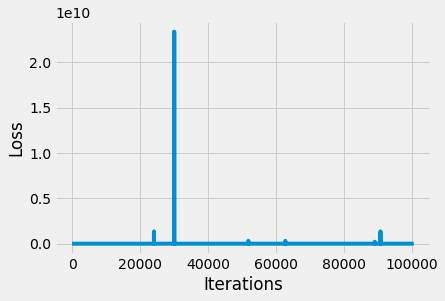

In [23]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses)

In [24]:
outputs[0]

(tensor([[ -1.0000,   0.0000,   1.0000,   0.0000,  79.0000,  -1.0000,  -1.0000,
           -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,
           -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,
           -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,
           -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,
           -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,
           -1.0000],
         [ 18.0000,   0.0000,   1.0000,   0.0000,  76.0000,  -1.0000,  -1.0000,
            0.9000,   0.9000, 128.0000, 128.0000, 144.0000, 144.0000,  -1.0000,
           -1.0000,   1.2000,   1.2000,  34.0000,  34.0000, 136.0000,  97.0000,
           -1.0000,  -1.0000,  22.0000,  14.0000,  22.0000,  13.0000,  22.0000,
           14.0000, 158.0000, 120.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,
           -1.0000,  -1.0000,  -1.0000,  -1.0000,  98.4000,  97.2000,  -1.0000,
           -1.0000]

In [25]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
!pip install seaborn